In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.io

import math
import time

In [2]:
# The below function image_show(args) is to show the image outputs generated. 

def image_show(img,wname): #PRESS 'q' or 'esc' to stop the window or can also click on CROSS(X) button
    for i in range(len(img)):
        cv.imshow(wname[i],img[i])
    cv.waitKey(0)
    cv.destroyAllWindows()


In [3]:
stack_of_images = scipy.io.loadmat('stack.mat')

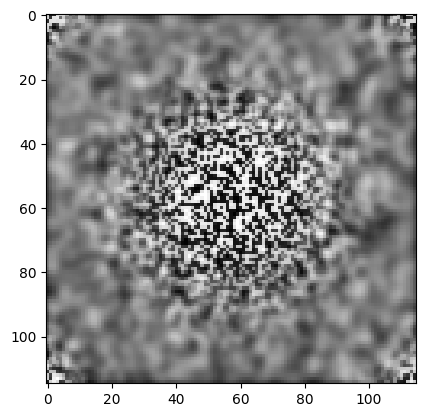

In [4]:
plt.imshow(stack_of_images['frame100'],cmap='gray')

In [5]:
stack_of_images['frame002'].shape

(115, 115)

In [6]:
list(stack_of_images.keys())[4],list(stack_of_images.keys())[103]

('frame001', 'frame100')

In [7]:
# delta_d is the distance between 2 subsequnt frames 
delta_d = 50.50

In [8]:
# Building the stack of images
STACK = []
KEYS = list(stack_of_images.keys())
for i in range(4,104):
    STACK.append(stack_of_images[KEYS[i]])

In [9]:
number_of_images = np.shape(STACK)[0]
number_of_images

100

In [10]:
image_shape = STACK[0].shape
image_shape

(115, 115)

In [11]:
# ray library for parallel processing 
import ray

ray.init()

2024-04-25 17:18:01,192	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.5', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

## Functions and procedure for SFF experiment

### apply_Kernel - applies a kernel on a given image

In [12]:
def apply_Kernel(image,kernel):
    # 'new_image' will store the kernel applied image
    new_image = np.zeros(image.shape)
    (rows,columns) = new_image.shape
    # 'mid' is the middle element of the kernel or WINDOW
    mid = kernel.shape[0]//2

    # The loop below will apply kernel on the image
    for i in range(rows):
        for j in range(columns):
            
            # CONSTRUCTING A WINDOW OF SIZE SAME AS KERNEL IN SOURCE IMAGE AROUND THE POINT (i,j) IN IMAGE        
            window = np.zeros(kernel.shape)
            (window_rows,window_cols) = window.shape

            # The loop below will fill the elements in the window from the source image
            for a in range(0-mid,window_rows-mid):
                for b in range(0-mid,window_cols-mid):
                    # if window is at corners then the cells outside the image are given zero value 
                    if 0<=a+i<rows and 0<=b+j<columns:
                        window[a+mid][b+mid] = image[i+a][j+b]
                    else:
                        window[a+mid][b+mid] = 0

            # element wise multiplication of kernel and window and then the values in 'k x k' matrix are all summed up --
            # -- and stored in the new_image[i][j]
            new_image[i][j] = np.sum(window*kernel)

    return new_image

### apply_Kernel_parallel - applies a kernel on a given image in parallel fashion

In [13]:
@ray.remote
def apply_Kernel_parallel(image,kernel):
    # 'new_image' will store the kernel applied image
    new_image = np.zeros(image.shape)
    (rows,columns) = new_image.shape
    # 'mid' is the middle element of the kernel or WINDOW
    mid = kernel.shape[0]//2

    # The loop below will apply kernel on the image
    for i in range(rows):
        for j in range(columns):
            
            # CONSTRUCTING A WINDOW OF SIZE SAME AS KERNEL IN SOURCE IMAGE AROUND THE POINT (i,j) IN IMAGE        
            window = np.zeros(kernel.shape)
            (window_rows,window_cols) = window.shape

            # The loop below will fill the elements in the window from the source image
            for a in range(0-mid,window_rows-mid):
                for b in range(0-mid,window_cols-mid):
                    # if window is at corners then the cells outside the image are given zero value 
                    if 0<=a+i<rows and 0<=b+j<columns:
                        window[a+mid][b+mid] = image[i+a][j+b]
                    else:
                        window[a+mid][b+mid] = 0

            # element wise multiplication of kernel and window and then the values in 'k x k' matrix are all summed up --
            # -- and stored in the new_image[i][j]
            new_image[i][j] = np.sum(window*kernel)

    return new_image

### Modified_Laplacian - Calculates the Modified laplacian of a given image

In [14]:
@ray.remote
## For comments refer lab-5 apply_kernel function code
def Modified_Laplacian(image):
    Fxx = np.array([[0,0,0],[1,-2,1],[0,0,0]])  # Double derivative in X-direction
    Fyy = np.array([[0,1,0],[0,-2,0],[0,1,0]])  # Double derivative in Y-direction
    parallelise = True
    if parallelise==True:
        args = [(image,Fxx),(image,Fyy)]
        output = [apply_Kernel_parallel.remote(image,Fxx),apply_Kernel_parallel.remote(image,Fyy)]
        out_value = ray.get(output)
        output_sum = np.abs(out_value[0]) + np.abs(out_value[1])
        return output_sum
    
    else:
        ML = np.abs(apply_Kernel(image=image,kernel=Fxx)) + np.abs(apply_Kernel(image=image,kernel=Fyy))
        return ML
    

### Sum_Modified_Laplacian - Calculates the sum modified laplcian given modified laplacian of an image

In [15]:
# check neighbourhood size wala parameter
@ray.remote
def Sum_Modified_Laplacian(ML_image,neighbourhood_size):
    if neighbourhood_size==1:
        kernel = np.ones((3,3))
    elif neighbourhood_size==0:
        kernel = np.ones((1,1))
    elif neighbourhood_size==2:
        kernel = np.ones((5,5))
    elif neighbourhood_size==6:
        kernel = np.zeros((13,13))
        
    SML_image = apply_Kernel(ML_image,kernel)
    return SML_image

### apply_ML_on_STACK - Applies Modified_Laplacian on the given STACK of images 

In [16]:
def apply_ML_on_STACK():
    ML_images_STACK = []

    output = [Modified_Laplacian.remote(img) for img in STACK]
    out_value = ray.get(output)
    ML_images_STACK = list(out_value)
    return ML_images_STACK
    

In [17]:
start = time.perf_counter()
ML_image_STACK = apply_ML_on_STACK()
finish = time.perf_counter()
finish-start

23.789348600000004

In [18]:
ML_image_STACK[99][0][0]

584.0

In [19]:
ML_image_STACK[0][0][0]

112.0

### apply_SML_on_STACK - applies SML function on the given STACK of images 

In [20]:
def apply_SML_on_STACK(neighbourhood_size):
    SML_STACK = []
    output = [Sum_Modified_Laplacian.remote(img,neighbourhood_size) for img in ML_image_STACK]
    out_value = ray.get(output)
    SML_STACK = list(out_value)
    return SML_STACK
    

In [21]:
start = time.perf_counter()
SML_STACK_0 = apply_SML_on_STACK(neighbourhood_size=0)
SML_STACK_1 = apply_SML_on_STACK(neighbourhood_size=1)
SML_STACK_2 = apply_SML_on_STACK(neighbourhood_size=2)
finish = time.perf_counter()
finish-start

19.398530900000004

In [22]:
SML_STACK_2[0] - SML_STACK_1[0]

array([[122., 123., 297., ..., 266., 111., 107.],
       [123., 122., 355., ..., 322., 115., 111.],
       [296., 354., 593., ..., 532., 320., 265.],
       ...,
       [267., 324., 533., ..., 587., 352., 292.],
       [110., 112., 318., ..., 352., 125., 123.],
       [108., 110., 267., ..., 290., 124., 121.]])

In [23]:
## Now we have got the Focus operateor operated images

In [24]:
np.shape(SML_STACK_0),np.shape(SML_STACK_1),np.shape(SML_STACK_2)

((100, 115, 115), (100, 115, 115), (100, 115, 115))

### gaussian_interpolation_parameters - Computes the gaussian fitting parameters at a pixel given relevant data

In [25]:
def gaussian_interpolation_parameters(a,ad,b,bd,c,cd):
    
    d_bar = (((np.log(a) - np.log(b))*(cd**2 - ad**2)) - ((np.log(a) - np.log(c))*(bd**2 - ad**2)))/(2*delta_d*(2*np.log(a) - np.log(c) - np.log(b)))
    sigma = np.sqrt(((bd - d_bar)**2 - (ad - d_bar)**2)/(2*(np.log(a) - np.log(b))))    
    FP = a/np.exp(-(ad - d_bar)**2/sigma**2)

    #if d_bar==np.nan:
     #   print((bd - d_bar)**2,(ad - d_bar)**2,np.log(a),np.log(b))
        
    return (d_bar,sigma,FP)

### apply_gaussian_interpolation - finds gaussian fitting at a pixel for the focus operator

In [26]:
def apply_gaussian_interpolation(SML_STACK_at_a_pixel):
    max_index = np.argmax(SML_STACK_at_a_pixel)
    a = SML_STACK_at_a_pixel[max_index] #max value
    ad = max_index*delta_d
    
    if max_index-1>=0:
        b = SML_STACK_at_a_pixel[max_index-1]
        bd = (max_index-1)*delta_d
    else:
        b = a
        bd = ad

    if max_index+1<number_of_images:
        c = SML_STACK_at_a_pixel[max_index+1]
        cd = (max_index+1)*delta_d
    else:
        c = a
        cd = ad

    (d_bar,sigma,FP) = gaussian_interpolation_parameters(a,ad,b,bd,c,cd)
    return (d_bar,sigma,FP,max_index)

### apply_gaussian_interpolation_on_all_pixels - Fits gaussian on all the pixels of the image 

In [27]:
def apply_gaussian_interpolation_on_all_pixels(SML_STACK_given):
    d_bar_image = np.zeros(STACK[0].shape)
    sigma_image = np.zeros_like(d_bar_image)
    FP_image = np.zeros_like(sigma_image)
    focused_image_index = np.zeros(STACK[0].shape,dtype=np.uint8)
    
    for i in range(image_shape[0]):
        for j in range(image_shape[1]):
            (d_bar_image[i][j],sigma_image[i][j],FP_image[i][j],focused_image_index[i][j]) = apply_gaussian_interpolation([SML_STACK_given[k][i][j] for k in range(number_of_images)])
    
    return (d_bar_image,sigma_image,FP_image,focused_image_index)
            

In [28]:
(d_bar_image_0,sigma_image_0,FP_image_0,focused_image_index_0) = apply_gaussian_interpolation_on_all_pixels(SML_STACK_0)
(d_bar_image_1,sigma_image_1,FP_image_1,focused_image_index_1) = apply_gaussian_interpolation_on_all_pixels(SML_STACK_1)
(d_bar_image_2,sigma_image_2,FP_image_2,focused_image_index_2) = apply_gaussian_interpolation_on_all_pixels(SML_STACK_2)

C:\Users\Dell DXCR203\AppData\Local\Temp\ipykernel_23676\2394791966.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(((bd - d_bar)**2 - (ad - d_bar)**2)/(2*(np.log(a) - np.log(b))))
C:\Users\Dell DXCR203\AppData\Local\Temp\ipykernel_23676\2394791966.py:3: RuntimeWarning: invalid value encountered in scalar divide
  d_bar = (((np.log(a) - np.log(b))*(cd**2 - ad**2)) - ((np.log(a) - np.log(c))*(bd**2 - ad**2)))/(2*delta_d*(2*np.log(a) - np.log(c) - np.log(b)))
C:\Users\Dell DXCR203\AppData\Local\Temp\ipykernel_23676\2394791966.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(((bd - d_bar)**2 - (ad - d_bar)**2)/(2*(np.log(a) - np.log(b))))


### retreive_focused_image 

In [29]:
def retreive_focused_image(focused_image_index_given):
    focused_image = np.zeros_like(STACK[0])

    for i in range(image_shape[0]):
        for j in range(image_shape[1]):
            focused_image[i][j] = STACK[focused_image_index_given[i][j]][i][j]

    return focused_image

In [30]:
focused_image_retrieved_0 = retreive_focused_image(focused_image_index_0)
focused_image_retrieved_1 = retreive_focused_image(focused_image_index_1)
focused_image_retrieved_2 = retreive_focused_image(focused_image_index_2)

Text(0.5, 1.0, 'FOCUSED IMAGE For neighbourhood_size=2')

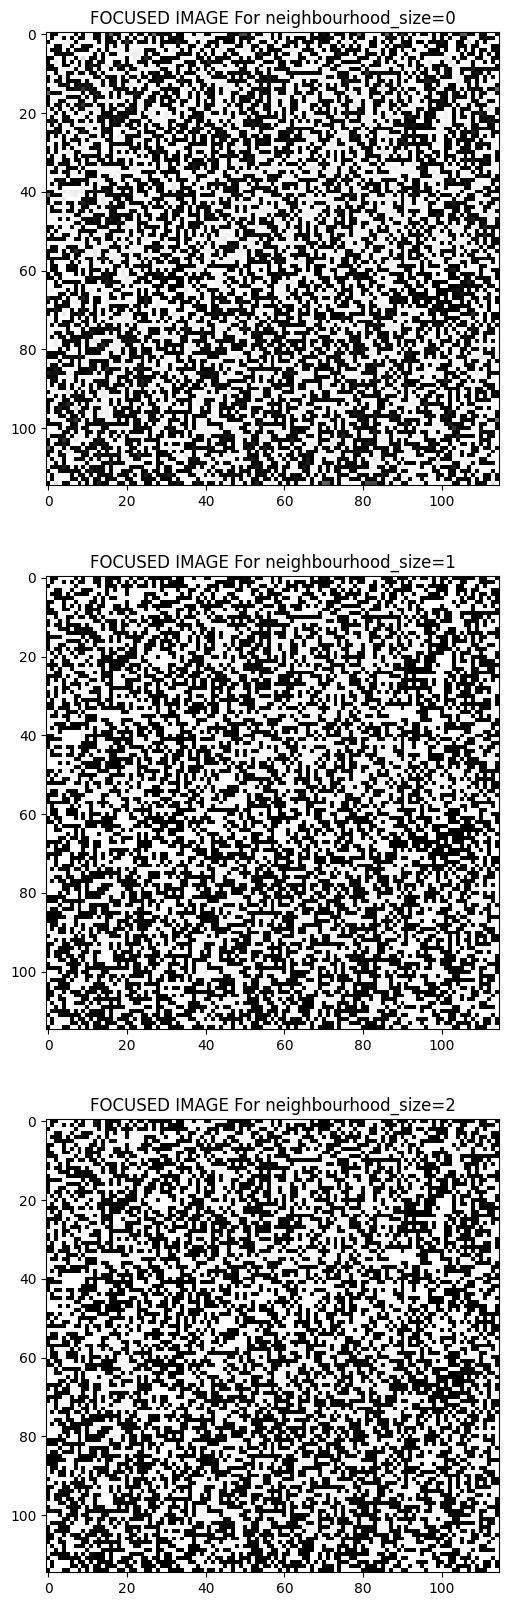

In [31]:
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(3,1,1)
plt.imshow(focused_image_retrieved_0,cmap='gray')
plt.title('FOCUSED IMAGE For neighbourhood_size=0')

fig.add_subplot(3,1,2)
plt.imshow(focused_image_retrieved_1,cmap='gray')
plt.title('FOCUSED IMAGE For neighbourhood_size=1')

fig.add_subplot(3,1,3)
plt.imshow(focused_image_retrieved_2,cmap='gray')
plt.title('FOCUSED IMAGE For neighbourhood_size=2')

### Retrieved 3D-Shape of the body

Text(0.5, 1.0, 'd_bar neighbourhood_size=2')

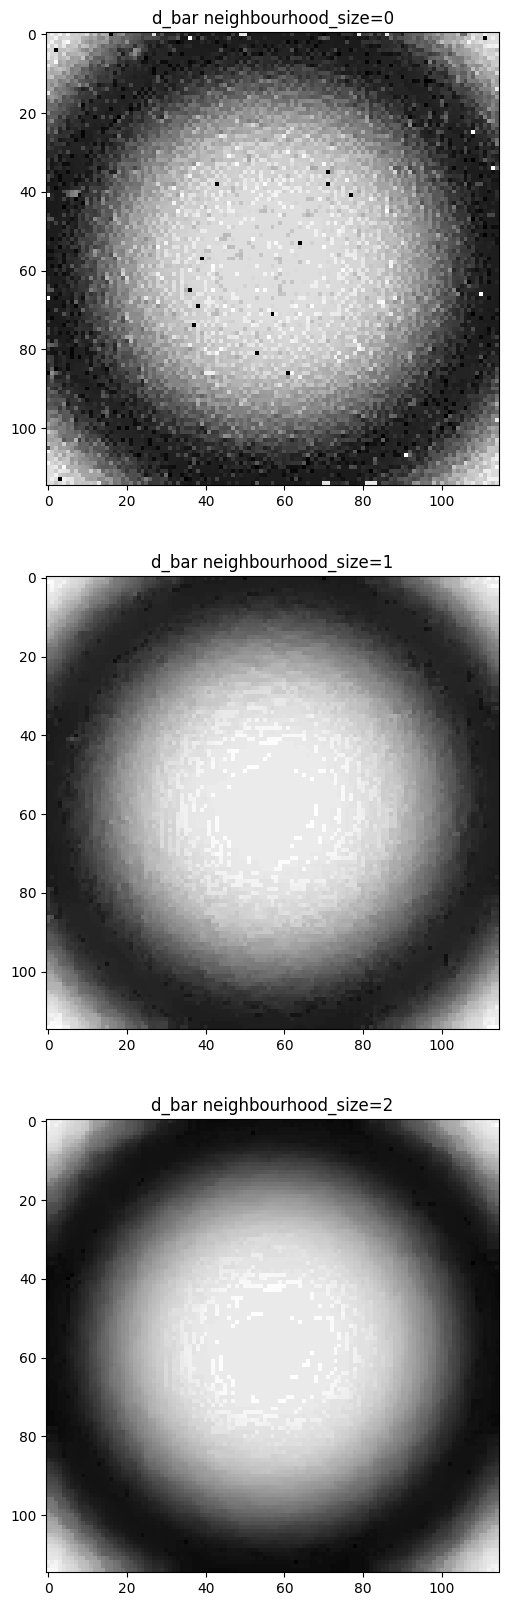

In [32]:
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(3,1,1)
plt.imshow(d_bar_image_0,cmap='gray')
plt.title('d_bar neighbourhood_size=0')

fig.add_subplot(3,1,2)
plt.imshow(d_bar_image_1,cmap='gray')
plt.title('d_bar neighbourhood_size=1')

fig.add_subplot(3,1,3)
plt.imshow(d_bar_image_2,cmap='gray')
plt.title('d_bar neighbourhood_size=2')


In [33]:
d_bar_image_0 = np.nan_to_num(d_bar_image_0,copy=True,nan=0)

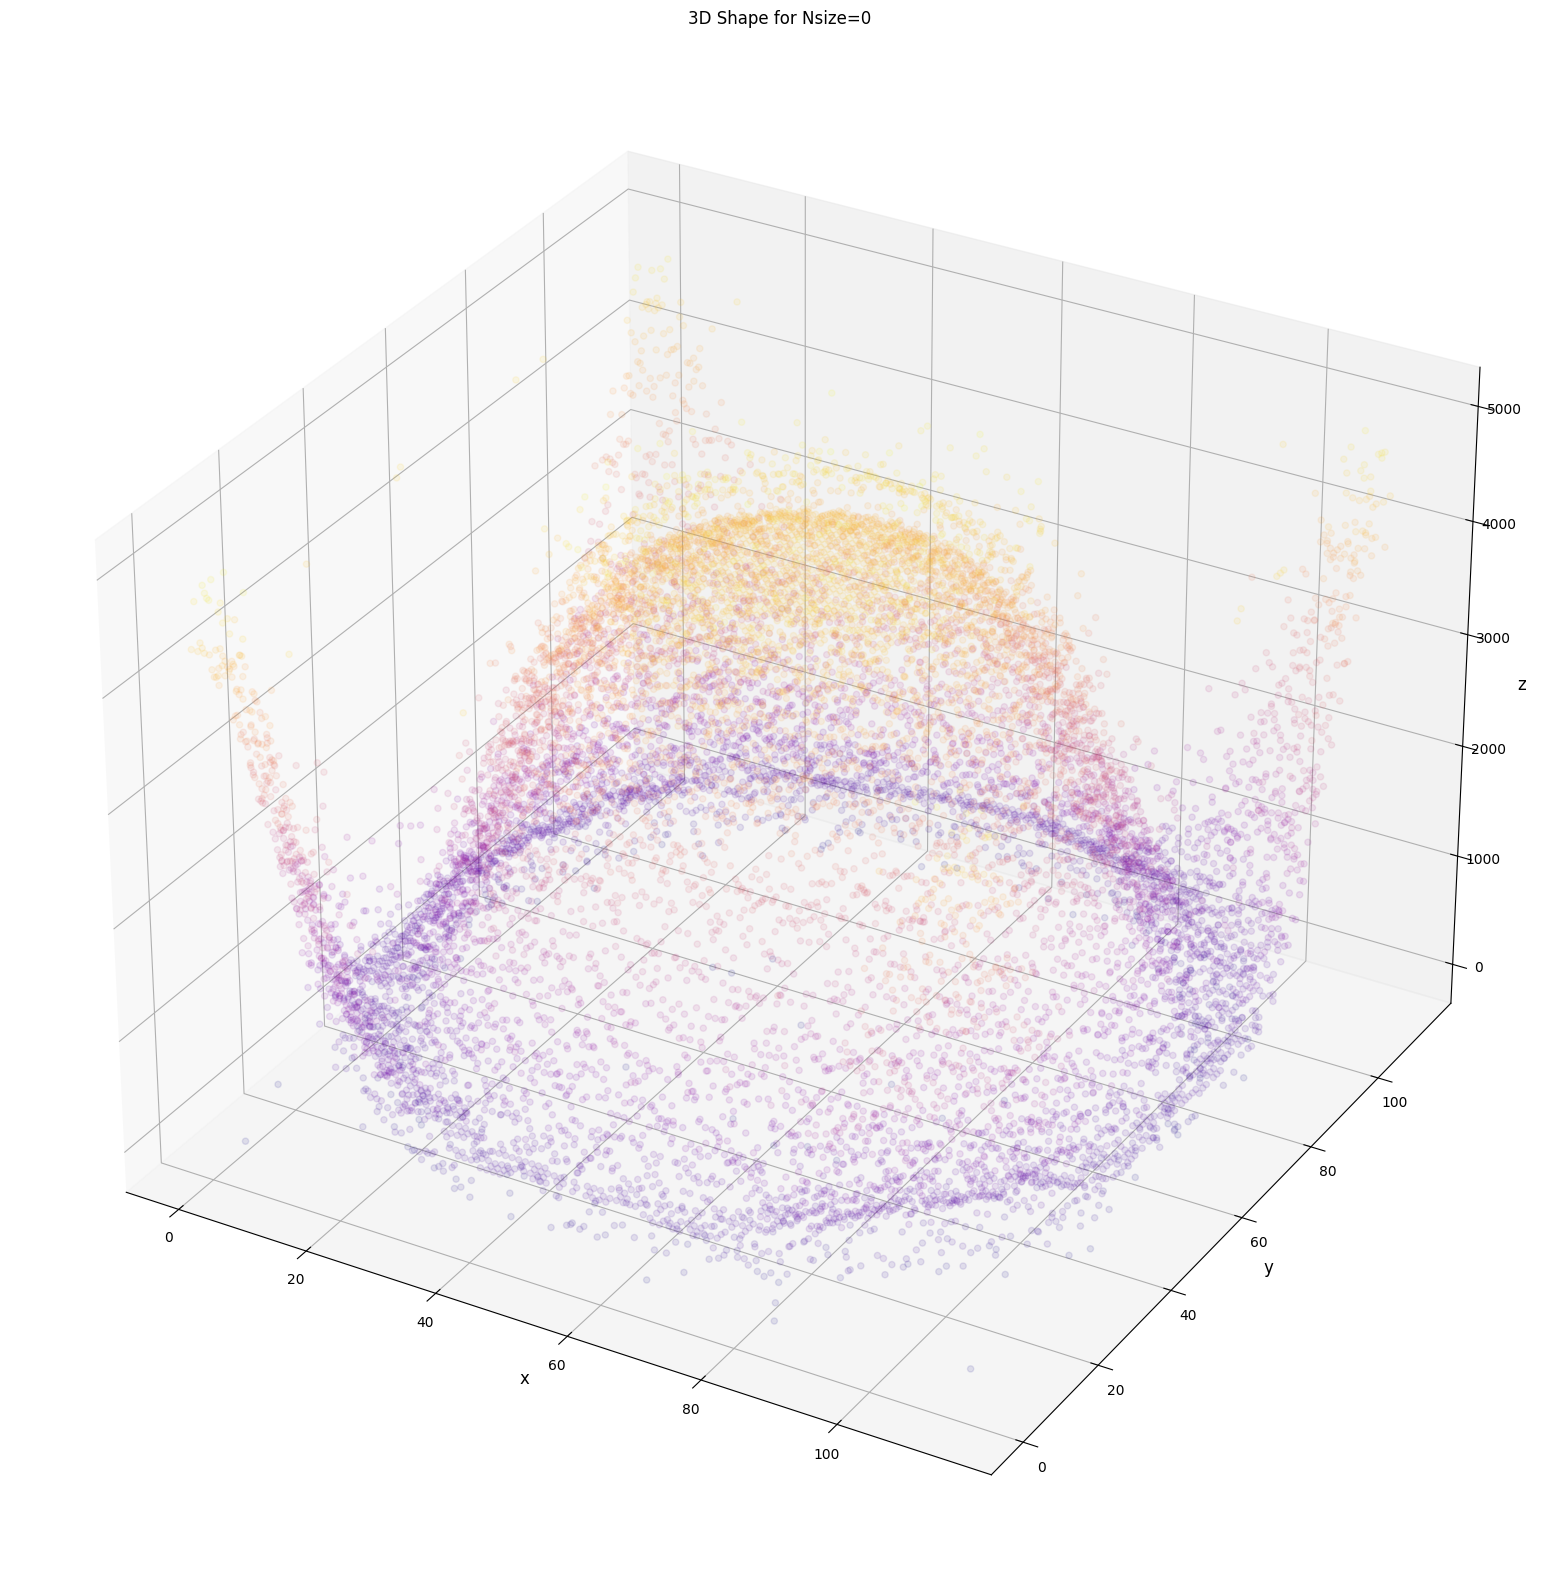

In [34]:
X = []
Y = []
Z0 = []
Z1 = []
Z2 = []
c0 = []
c1 = []
c2 = []
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        X.append(i)
        Y.append(j)
        Z0.append(d_bar_image_0[i][j])
        Z1.append(d_bar_image_1[i][j])
        Z2.append(d_bar_image_2[i][j])
        c0.append(int(d_bar_image_0[i][j]))
        c1.append(int(d_bar_image_1[i][j]))
        c2.append(int(d_bar_image_2[i][j]))
        
        
fig = plt.figure(figsize=(20, 20))
ax0 = plt.axes(projection='3d')
cmhot = plt.get_cmap("plasma")
ax0.scatter(X, Y, Z0, alpha=0.1,cmap=cmhot,c=c0)
ax0.set_xlabel('x', fontsize=12)
ax0.set_ylabel('y', fontsize=12)
ax0.set_zlabel('z', fontsize=12)
ax0.set_title('3D Shape for Nsize=0')
plt.show()

Text(0.5, 0.92, '3D Shape for Nsize=1')

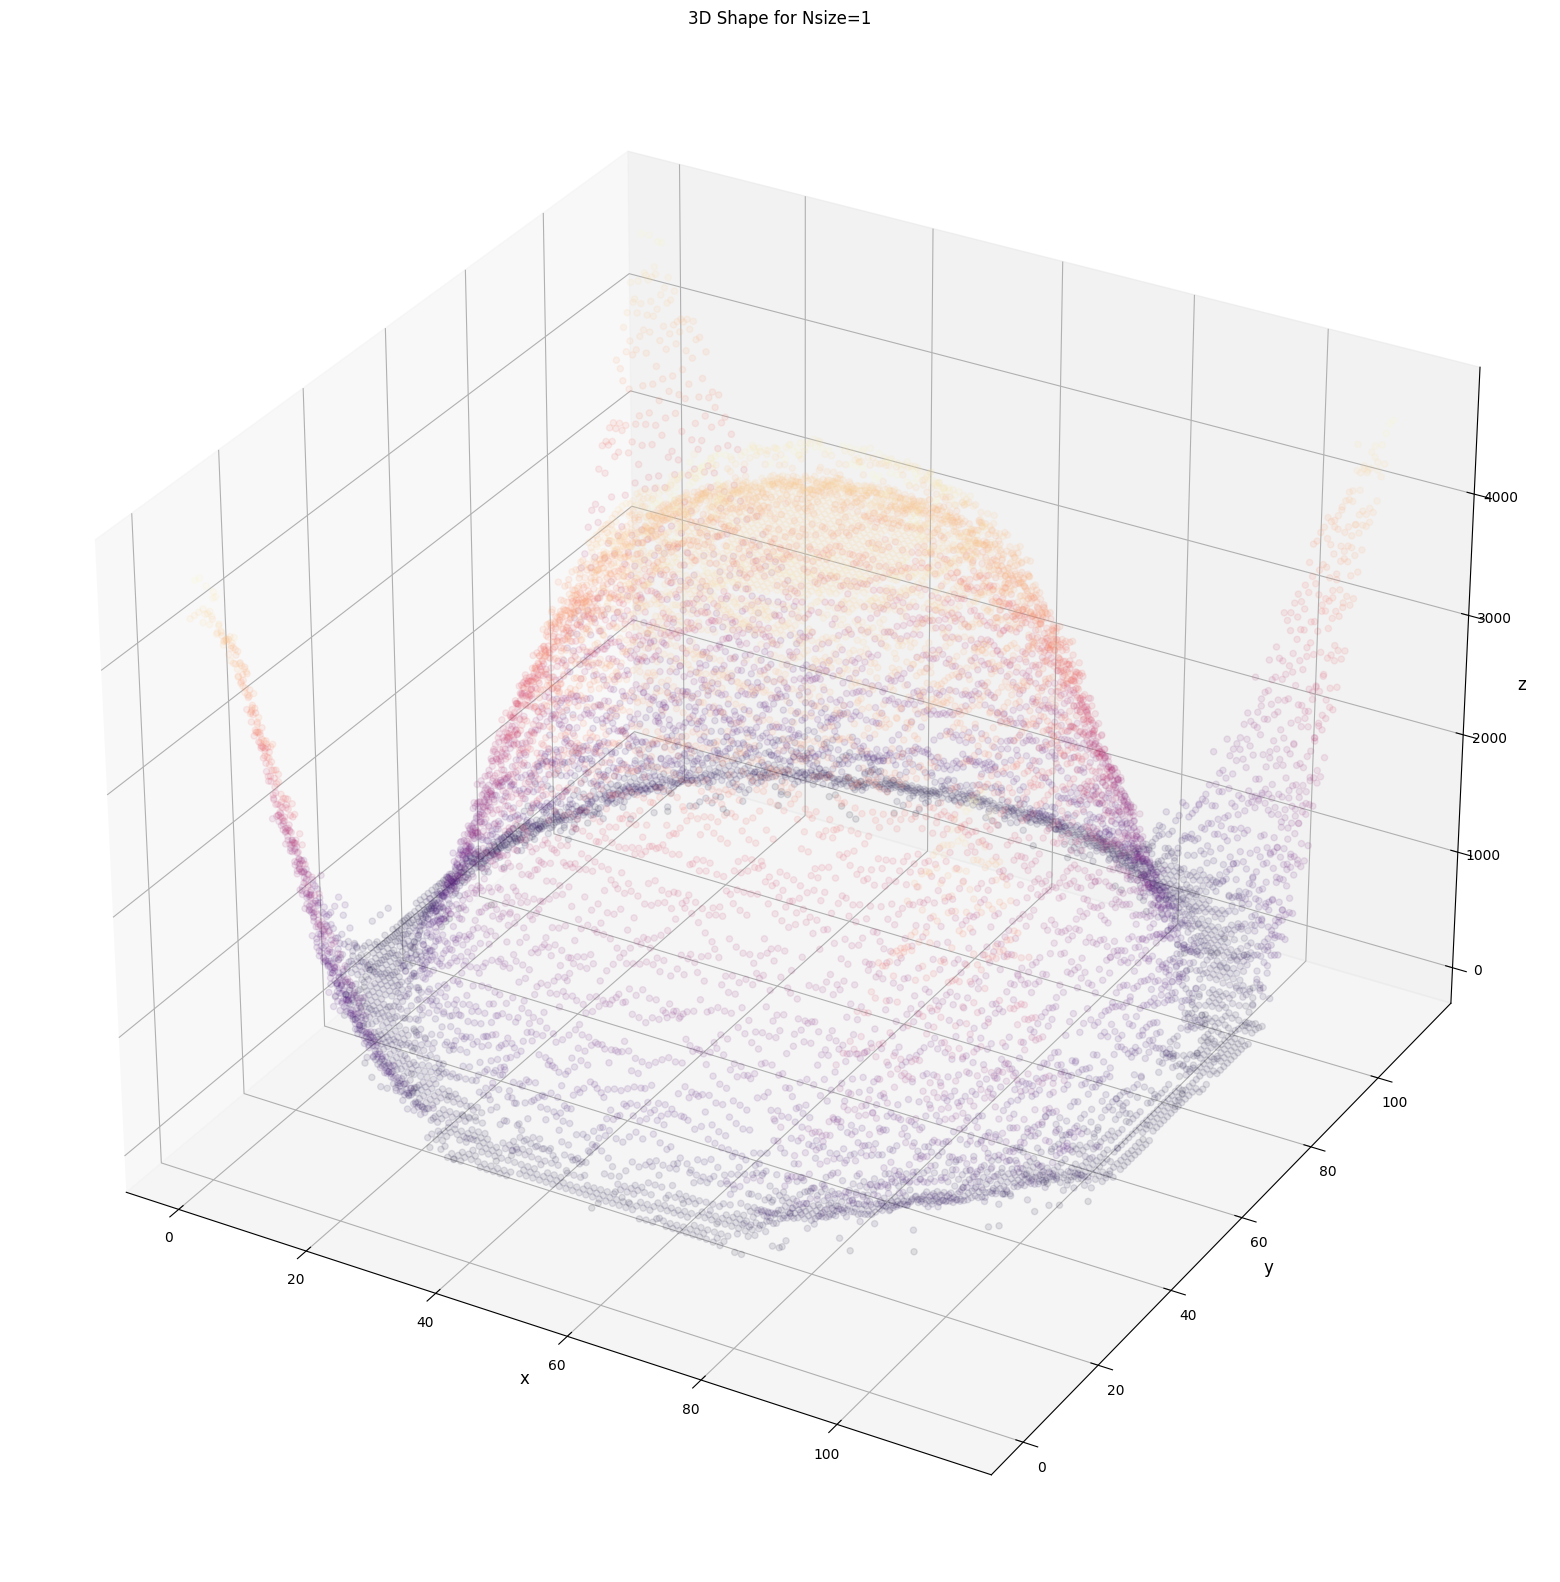

In [36]:
fig = plt.figure(figsize=(20, 20))
ax0 = plt.axes(projection='3d')
cmhot = plt.get_cmap("magma")
ax0.scatter(X, Y, Z1, alpha=0.1,cmap=cmhot,c=c1)
ax0.set_xlabel('x', fontsize=12)
ax0.set_ylabel('y', fontsize=12)
ax0.set_zlabel('z', fontsize=12)
ax0.set_title('3D Shape for Nsize=1')

Text(0.5, 0.92, '3D Shape for Nsize=2')

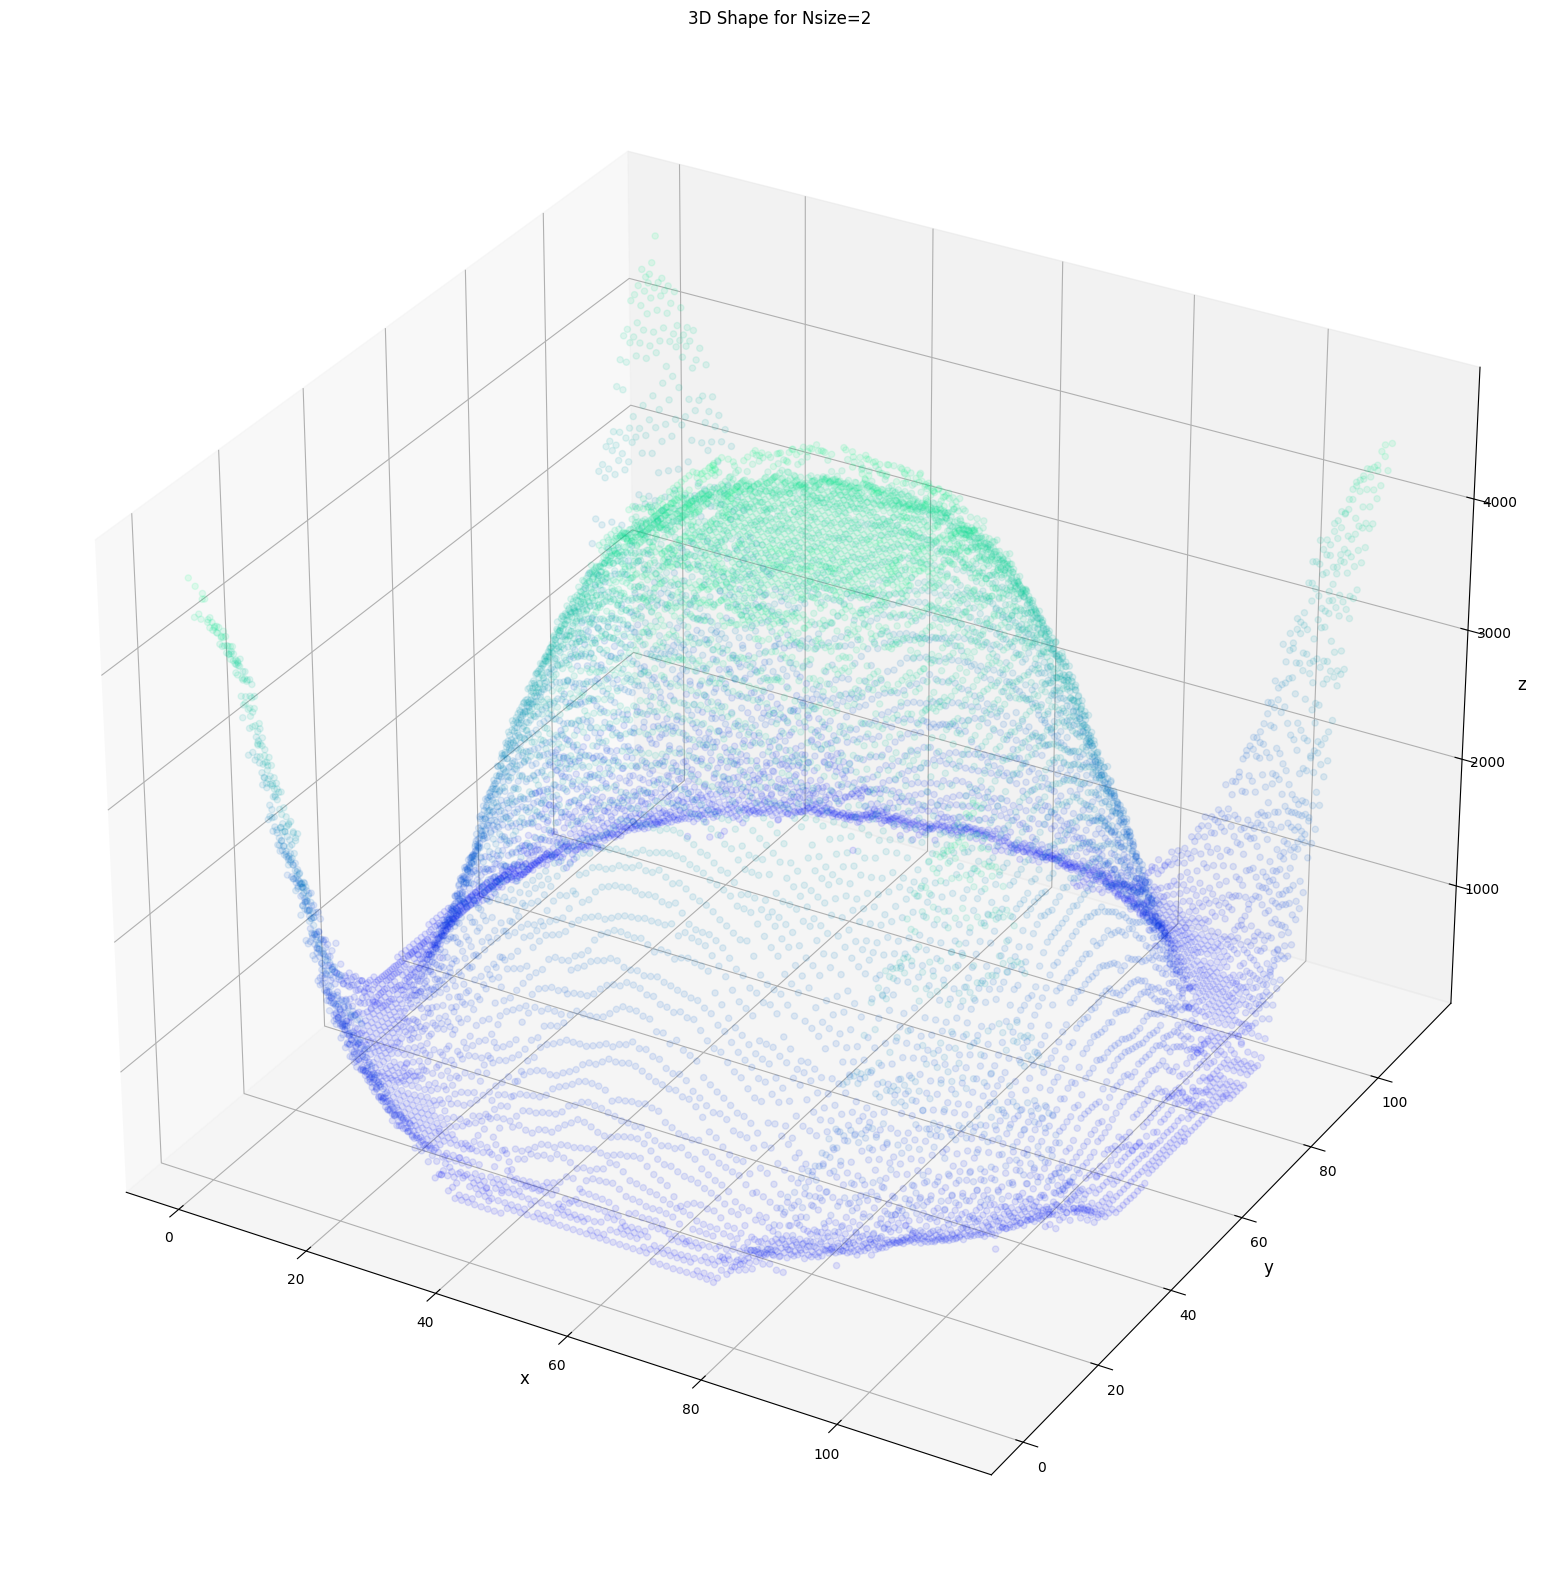

In [37]:
fig = plt.figure(figsize=(20, 20))
ax0 = plt.axes(projection='3d')
cmhot = plt.get_cmap("winter")
ax0.scatter(X, Y, Z2, alpha=0.1,cmap=cmhot,c=c2)
ax0.set_xlabel('x', fontsize=12)
ax0.set_ylabel('y', fontsize=12)
ax0.set_zlabel('z', fontsize=12)
ax0.set_title('3D Shape for Nsize=2')

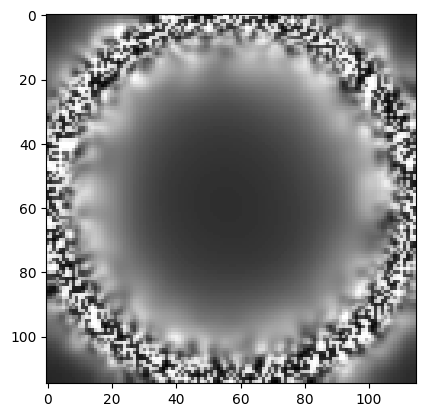

In [37]:
plt.imshow(STACK[0],cmap='gray')

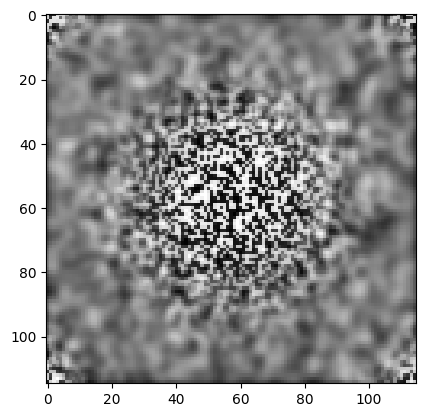

In [38]:
plt.imshow(STACK[99],cmap='gray')